In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
from imgaug import augmenters as iaa
from skimage.transform import resize
%matplotlib inline

In [2]:
data_root = '.' # Change me to store data elsewhere

#get all img files and create a dictionary
imgs = glob.glob('./*_DEG/**/*.JPG',recursive=True)
classes = {}
for img in imgs :
    clas = img.split('/')[4]
    try :
        classes[clas].append(img)
    except KeyError:
        classes[clas] = []

#check how many files do we have for each class
for key in classes.keys() :
    print(key + ': with Number --> ' +  str(len(classes[key])))

SLICY: with Number --> 2538
ZSU_23_4: with Number --> 1400
2S1: with Number --> 1163
BRDM_2: with Number --> 1414
ZIL131: with Number --> 572
T62: with Number --> 571
D7: with Number --> 572
BTR_60: with Number --> 450


In [4]:
num_classes = 4
np.random.seed(133)

#pick top num_classes from classes
while len(classes) > num_classes :
    classes.pop(min(classes,key= lambda x: len(classes[x])))

In [5]:
image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def zoom_to(img, shape):
    start = (img.shape[0]//2 - shape[0]//2,
             img.shape[1]//2 - shape[1]//2)
    end = (start[0] + shape[0], start[1] + shape[1])
    return img[start[0]:end[0],start[1]:end[1]]

def load_target(image_files):
  """Load the data for a target label."""

  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  num_images = 0
  for image in image_files:
    try:
      image_data = resize((imageio.imread(image).astype(float) - 
                    pixel_depth / 2) / pixel_depth, (image_size, image_size))
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images += 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

def augment_table(augmenter, dataset):
    ds = dataset * pixel_depth + pixel_depth / 2
    ret = np.zeros(ds.shape)
    for iii in range(ds.shape[0]) :
        ret[iii,:,:] = augmenter.augment_image(ds[iii,:,:])
    return (ret - pixel_depth/2) / pixel_depth

def augment(dataset, labels, pool):
    operations = [
#           iaa.AverageBlur(k=3),
         iaa.GaussianBlur(sigma=1),
#         iaa.Invert(1)],
         iaa.Multiply(1.5),
         iaa.Crop(px=(0, 16))
    ]
#         iaa.Flipud(1)],
#          iaa.Affine(rotate=90),
#         iaa.Affine(rotate=-90)]
#         iaa.Affine(shear=45)]
#          iaa.Affine(shear=-45)]
    nmax = 30000
    ds_len = dataset.shape[0] * len(operations)
    ds = np.array(pool.imgs, dtype=np.float32)
    labs = np.array(pool.labels, dtype=np.int32)
    for op in operations :
        ds = np.vstack((ds,augment_table(op, dataset)))
        labs = np.hstack((labs, labels))
    return ds, labs
        
def maybe_pickle(classes, force=False):
  dataset_names = []
  for folder in classes.keys():
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_target(classes[folder])
        
      #TODO: data augmentation goes here
      #dataset = (augment(dataset*pixel_depth +  pixel_depth / 2) - pixel_depth / 2) / pixel_depth
      #print(dataset.shape)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(classes,force=True)

Pickling SLICY.pickle.


/usr/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Full dataset tensor: (2538, 54, 54)
Mean: -0.3782606
Standard deviation: 0.14506215
Pickling ZSU_23_4.pickle.
Full dataset tensor: (1400, 54, 54)
Mean: -0.29280013
Standard deviation: 0.17620362
Pickling 2S1.pickle.
Full dataset tensor: (1163, 54, 54)
Mean: -0.124501675
Standard deviation: 0.24154055
Pickling BRDM_2.pickle.
Full dataset tensor: (1414, 54, 54)
Mean: -0.13962525
Standard deviation: 0.21734267


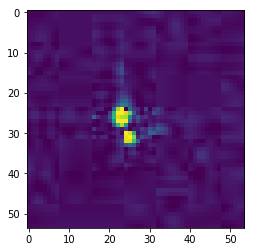

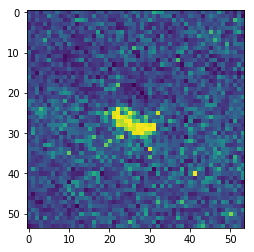

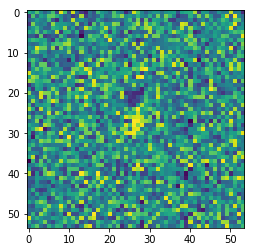

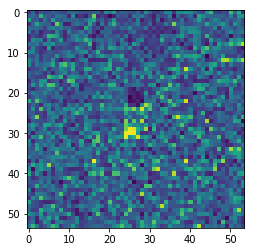

In [6]:
for my_fn in train_datasets :
    my_dat = pickle.load(open(my_fn, 'rb'))
    plt.imshow(my_dat[np.random.randint(0,1000)])
    plt.show()

In [7]:
# we are going to need it for dataset size calculation
shapes = []
for my_fn in train_datasets :
    my_dat = pickle.load(open(my_fn, 'rb'))
    print(my_fn + str(my_dat.shape))
    shapes.append(my_dat.shape)
shapes = np.array(shapes)

SLICY.pickle(2538, 54, 54)
ZSU_23_4.pickle(1400, 54, 54)
2S1.pickle(1163, 54, 54)
BRDM_2.pickle(1414, 54, 54)


In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size):
  test_size = valid_size
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  test_dataset, test_labels = make_arrays(test_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  pool = type('',(),{})()
  pool.labels = []
  pool.imgs = []
  current_v = 0;
  current_t = 0;
  for label, pickle_file in enumerate(pickle_files):       
    try: 
      with open(pickle_file, 'rb') as f:
        target_set = pickle.load(f)
        np.random.shuffle(target_set)
        if valid_dataset is not None:
          vsize = valid_size // num_classes
          tsize = train_size // num_classes
            
          valid_target = target_set[:vsize, :, :]
          test_target = target_set[vsize:2*vsize, :, :]
          train_target = target_set[2*vsize:2*vsize + tsize, :, :]
          rest = target_set[2*vsize + tsize:, :, :].tolist()
          pool.imgs += rest
          pool.labels += [label] * len(rest)
        
          valid_dataset[current_v:current_v+vsize, :, :] = valid_target
          test_dataset[current_v:current_v+vsize, :, :] = test_target
          train_dataset[current_t:current_t+tsize, :, :] = train_target
        
          valid_labels[current_v:current_v+vsize] = label
          test_labels[current_v:current_v+vsize] = label
          train_labels[current_t:current_t+tsize] = label
        
          current_v += vsize
          current_t += tsize
        
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, test_dataset, test_labels, train_dataset, train_labels, pool

valid_size =  300
test_size =   300
train_size = 4052

valid_dataset, valid_labels, test_dataset, test_labels, train_dataset, train_labels, pool= merge_datasets(
  train_datasets, train_size, valid_size)

#apply augmentation
ds, labs = augment(train_dataset, train_labels, pool)
train_dataset = np.vstack((train_dataset,ds))
train_labels = np.hstack((train_labels, labs))

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (18071, 54, 54) (18071,)
Validation: (300, 54, 54) (300,)
Testing: (300, 54, 54) (300,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

3


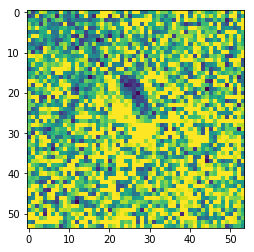

2


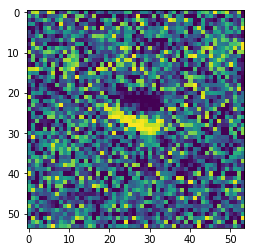

0


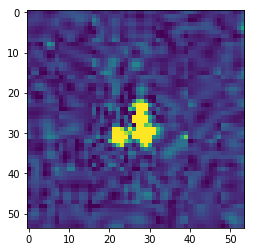

3


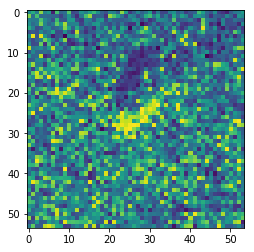

0


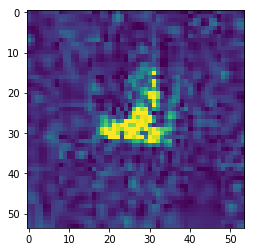

2


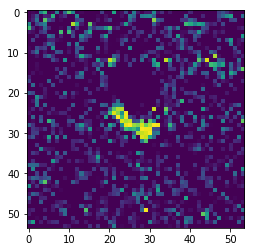

1


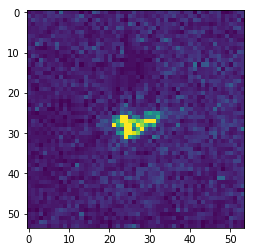

3


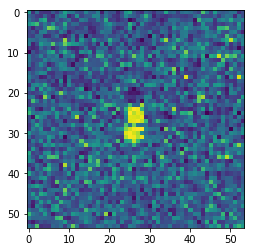

1


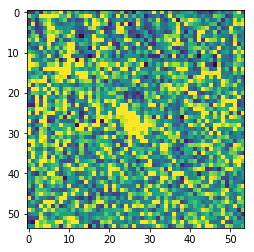

2


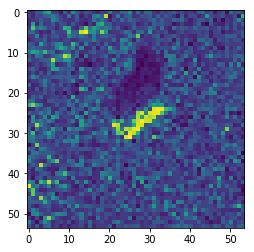

In [9]:
my_rn = np.random.randint(0,len(train_labels),10)
for iii in my_rn:
    print(train_labels[iii])
    plt.imshow(train_dataset[iii])
    plt.show()

Save the data for later reuse:

In [10]:
pickle_file = os.path.join(data_root, 'MSTAR.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 428633910


In [10]:
def imgs2hash(imgs):
    hashes = np.zeros(imgs.shape[0])
    for iii, img in enumerate(imgs):
        hashes[iii] = hash(img.tobytes())
    return hashes

trv = np.intersect1d(imgs2hash(train_dataset), imgs2hash(valid_dataset))
trt = np.intersect1d(imgs2hash(train_dataset), imgs2hash(test_dataset))
vt = np.intersect1d(imgs2hash(valid_dataset), imgs2hash(test_dataset))

print("number of intersection between:")
print("\tTrain / Valid:" + str(trv.shape))
print("\tTrain / Test:" + str(trt.shape))
print("\tValid / Test:" + str(vt.shape))

number of intersection between:
	Train / Valid:(0,)
	Train / Test:(0,)
	Valid / Test:(0,)


In [11]:
scores = []
def train_N(N):
    model = LogisticRegression()
    X = train_dataset[:N]
    print(X.shape)
    n = min(N,X.shape[0])
    X = X.reshape(n,X.shape[1]**2)
    print('Training ' + str(N) + ' samples')
    model.fit(X,train_labels[:N])
    T = test_dataset.reshape((test_dataset.shape[0],test_dataset.shape[1]**2))
    print('Testing ' + str(N) + ' samples')
    scores.append(model.score(T, test_labels))
    
for iii in [50, 100, 1000, 5000]:
    train_N(iii)
    
print(scores)

(50, 54, 54)
Training 50 samples


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing 50 samples
(100, 54, 54)
Training 100 samples
Testing 100 samples
(1000, 54, 54)
Training 1000 samples


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing 1000 samples
(5000, 54, 54)
Training 5000 samples


/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing 5000 samples
[0.56, 0.64, 0.8066666666666666, 0.8166666666666667]
